In [1]:
import json, glob, pycm, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from operator import itemgetter
from IPython.display import display, Markdown

In [2]:
def display_experiment(experiment):
    display(Markdown(f'## {experiment["concept"]["label"]} ({experiment["concept"]["id"]})'))
    display(Markdown(experiment["concept"]["definition"]))
    display(Markdown("### Confusion matrix"))
    cm = pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"])
    df_cm = pd.DataFrame(cm.matrix).T.fillna(0)
    ax = sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")
    ax.set_title(experiment["concept"]["label"])
    ax.set(xlabel='LLM', ylabel='KG')
    plt.show()
    df = pd.DataFrame.from_records(experiment["data"])
    df_fp = df[((df["actual"] == 'negative') & (df["predicted"] == 'positive'))][["label", "description", "rationale"]]
    if len(df_fp) > 0:
        df_fp_styler = df_fp.style.set_properties(**{"text-align": "left", "vertical-align" : "top", "overflow-wrap": "break-word"}).hide(axis="index")
        display(Markdown("### LLM positive, KG negative"))
        display(df_fp_styler)
    df_fn = df[((df["actual"] == 'positive') & (df["predicted"] == 'negative'))][["label", "description", "rationale"]]
    if len(df_fn) > 0:
        df_fn_styler = df_fn.style.set_properties(**{"text-align": "left", "vertical-align" : "top", "overflow-wrap": "break-word"}).hide(axis="index")
        display(Markdown("### LLM negative, KG positive"))
        display(df_fn_styler)

In [3]:
experiments = [ experiment for experiment in json.load(open('../experiments/planet_gpt-4_description_results.json', 'r')) if "confusion_matrix" in experiment ]

In [4]:
experiment_df = pd.DataFrame.from_records([ 
    { 
        "name": experiment["concept"]['id'], 
        "kappa": pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).Kappa,
        "SOA9": pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).SOA9,
        "ACC": f'{pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).Overall_ACC:.1%}',
        "FP": pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).FP["positive"],
        "FN": pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).FN["positive"],
        "POP": pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).POP["positive"],
        "experiment": experiment,
    }
    for experiment in experiments if pycm.ConfusionMatrix(matrix=experiment["confusion_matrix"]).Kappa != 'None'  ]).sort_values("kappa", ascending=False)
experiment_df[["name", "kappa", "SOA9", "ACC", "FP", "FN", "POP"]]

,name,kappa,SOA9,ACC,FP,FN,POP
2,oed_planet,0.78,Tentative,89.0%,0,11,100
1,iau_2006_08_16_planet,0.60,Low,80.0%,0,20,100
0,iau_2006_08_24_planet,0.48,Low,74.0%,0,26,100


In [5]:
experiment_df.describe()

,kappa,FP,FN,POP
count,3.000000,3.0,3.000000,3.0
mean,0.620000,0.0,19.000000,100.0
std,0.150997,0.0,7.549834,0.0
min,0.480000,0.0,11.000000,100.0
25%,0.540000,0.0,15.500000,100.0
50%,0.600000,0.0,20.000000,100.0
75%,0.690000,0.0,23.000000,100.0
max,0.780000,0.0,26.000000,100.0


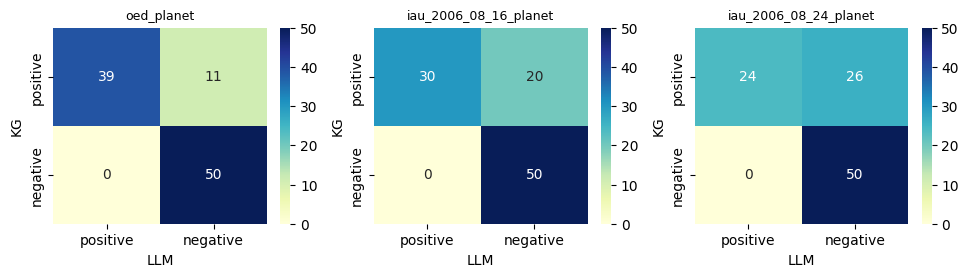

In [6]:
fig = plt.figure(figsize=(20,14))
gs = fig.add_gridspec(4, 5, hspace=0.5)
axes = gs.subplots()
cms = [ (experiment["name"], pycm.ConfusionMatrix(matrix=experiment["experiment"]["confusion_matrix"])) for experiment in experiment_df.to_dict('records')  ]
for ax, (name, cm) in zip(axes.flat, cms):
    df = pd.DataFrame(cm.matrix).T.fillna(0)
    sns.heatmap(df, annot=True, fmt='d', cmap="YlGnBu", ax=ax)
    ax.set_title(name, wrap=True, fontsize=9)
    ax.set(xlabel='LLM', ylabel='KG')
for ax in axes.flat[len(cms):]:
    ax.set_visible(False)
plt.show()

## planet (oed_planet)

Any of various rocky or gaseous bodies that revolve in approximately elliptical orbits around the sun and are visible by its reflected light; esp. each of the planets Mercury, Venus, Earth, Mars, Jupiter, Saturn, Uranus, Neptune, and (until 2006) Pluto (in order of increasing distance from the sun); a similar body revolving around another star. Also: any of various smaller bodies that revolve around these (cf. satellite n. 2a).

### Confusion matrix

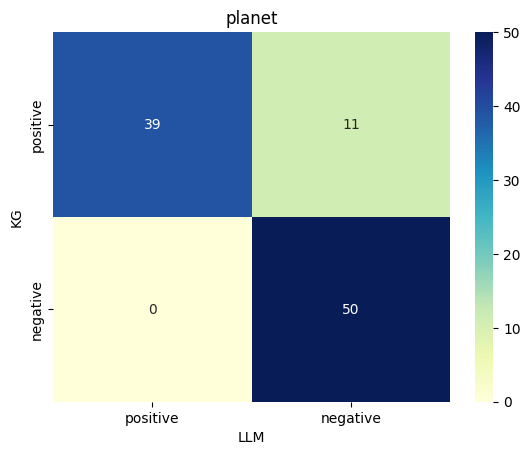

### LLM negative, KG positive

label,description,rationale
HD 202206 b,"HD 202206 is a binary star system in the southern constellation of Capricornus. With an apparent visual magnitude of +8.1, it is too faint to be visible to the naked eye. It is located at a distance of 150 light years from the Sun based on parallax, and is drifting further away with a radial velocity of +14.7 km/s.The primary component is a G-type main-sequence star with a stellar classification of G6V, indicating it is generating energy through core hydrogen fusion. It is an estimated three billion years old and is spinning with a projected rotational velocity of 2.3 km/s. It is a metal-rich star – what astronomers term the abundance of elements of higher atomic number than helium – which may explain the star's unusually high luminosity for its class. The star has a slightly greater mass and radius compared to the Sun.","The definition provided does not give enough information to definitively assert that HD 202206 b is a planet. The description of HD 202206 b refers to it as a binary star system, not a body that revolves around a star. Therefore, based on the given definition of a planet, we cannot argue that HD 202206 b is a planet."
K2-187e,"K2-187, also known as EPIC 212157262, is a Sun-like star in K2 Campaign 5. It is very close in size and temperature to the Sun, and has a system of four confirmed exoplanets ranging between 1.4 R🜨 and 3.2 R🜨. The innermost planet takes just 18 hours to orbit its star, while the outermost planet orbits every 2 weeks.","The assertion that K2-187e is a planet cannot be supported based on the given definition and information. According to the definition, a planet is a body that revolves in an elliptical orbit around the sun or another star and is visible by its reflected light. However, the provided information about K2-187e describes it as a Sun-like star with a system of four confirmed exoplanets. It does not indicate that K2-187e itself revolves around another star, which is a key characteristic of a planet according to the given definition. Therefore, based on the provided information and definition, K2-187e cannot be classified as a planet."
Gliese 686 b,"Gliese 686 (GJ 686 / HIP 86287 / LHS 452) is a star in the constellation of Hercules, with an apparent magnitude +9.577. Although it is close to the Solar System - at 26.5 light years - it is not the closest known star in its constellation, since Gliese 661 is 20.9 light years away. The closest system to this star is the bright μ Herculis, at 4.5 light years. They are followed by GJ 1230 and Gliese 673, at 7.2 and 7.6 light years respectively.Gliese 686 is one of the many red dwarfs in the Solar System neighborhood with a spectral type of M1V, and has an effective temperature of about 3600 K. Its brightness in the visible spectrum is equal to 0.82% of that of the Sun, while its total luminosity is equivalent to 2.7% that of the Sun, since a significant amount of the radiation emitted by these stars is infrared invisible light. Considering only this last parameter, Gliese 686 is considerably brighter than other known red dwarfs; thus, it is 6.5 times more luminous than Ross 154 and 15 times more than Proxima Centauri, the closest star to the Solar System. Gliese 686 has a radius approximately equal to half the solar radius. Its projected rotation speed is 2.5 km / s, its rotation period being equal to or less than 10.3 days. It has a metallic content lower than that of the Sun; various studies estimate its index metallicity between -0.25 and -0.44. It has an approximate mass between 45% and 49% of the solar mass and is a star with characteristics comparable to that of Lacaille 9352.","The text does not provide sufficient information to assert that Gliese 686 b is a planet. The provided description only discusses the characteristics of Gliese 686, which is a star, not a planet. There is no mention of any body revolving around this star, which would be necessary to classify something as a planet a

## planet (iau_2006_08_16_planet)

A planet is a celestial body that (a) has sufficient mass for its self-gravity to overcome rigid body forces so that it assumes a hydrostatic equilibrium (nearly round) shape, and (b) is in orbit around a star, and is neither a star nor a satellite of a planet.

### Confusion matrix

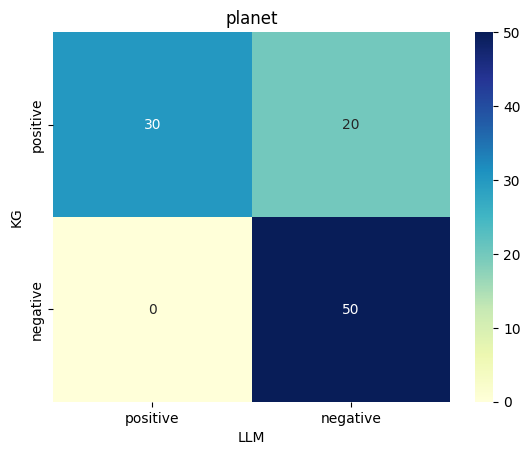

### LLM negative, KG positive

label,description,rationale
HD 202206 b,"HD 202206 is a binary star system in the southern constellation of Capricornus. With an apparent visual magnitude of +8.1, it is too faint to be visible to the naked eye. It is located at a distance of 150 light years from the Sun based on parallax, and is drifting further away with a radial velocity of +14.7 km/s.The primary component is a G-type main-sequence star with a stellar classification of G6V, indicating it is generating energy through core hydrogen fusion. It is an estimated three billion years old and is spinning with a projected rotational velocity of 2.3 km/s. It is a metal-rich star – what astronomers term the abundance of elements of higher atomic number than helium – which may explain the star's unusually high luminosity for its class. The star has a slightly greater mass and radius compared to the Sun.","The provided description does not provide sufficient information to assert that HD 202206 b is a planet. The description primarily focuses on the characteristics of the star system HD 202206 and its primary component, a G-type main-sequence star. There is no information given about any celestial body within this system that would meet the criteria of a planet as defined above. Therefore, based on the provided information, we cannot argue that HD 202206 b is a planet."
K2-187e,"K2-187, also known as EPIC 212157262, is a Sun-like star in K2 Campaign 5. It is very close in size and temperature to the Sun, and has a system of four confirmed exoplanets ranging between 1.4 R🜨 and 3.2 R🜨. The innermost planet takes just 18 hours to orbit its star, while the outermost planet orbits every 2 weeks.","The provided description does not provide sufficient information to assert that K2-187e is a planet. The description identifies K2-187 as a star with a system of four confirmed exoplanets, but it does not specify whether K2-187e is one of these exoplanets or if it meets the criteria outlined in the definition of a planet. Therefore, based on the given information, we cannot argue that K2-187e is a planet."
Gliese 686 b,"Gliese 686 (GJ 686 / HIP 86287 / LHS 452) is a star in the constellation of Hercules, with an apparent magnitude +9.577. Although it is close to the Solar System - at 26.5 light years - it is not the closest known star in its constellation, since Gliese 661 is 20.9 light years away. The closest system to this star is the bright μ Herculis, at 4.5 light years. They are followed by GJ 1230 and Gliese 673, at 7.2 and 7.6 light years respectively.Gliese 686 is one of the many red dwarfs in the Solar System neighborhood with a spectral type of M1V, and has an effective temperature of about 3600 K. Its brightness in the visible spectrum is equal to 0.82% of that of the Sun, while its total luminosity is equivalent to 2.7% that of the Sun, since a significant amount of the radiation emitted by these stars is infrared invisible light. Considering only this last parameter, Gliese 686 is considerably brighter than other known red dwarfs; thus, it is 6.5 times more luminous than Ross 154 and 15 times more than Proxima Centauri, the closest star to the Solar System. Gliese 686 has a radius approximately equal to half the solar radius. Its projected rotation speed is 2.5 km / s, its rotation period being equal to or less than 10.3 days. It has a metallic content lower than that of the Sun; various studies estimate its index metallicity between -0.25 and -0.44. It has an approximate mass between 45% and 49% of the solar mass and is a star with characteristics comparable to that of Lacaille 9352.","The provided description does not provide sufficient information to assert that Gliese 686 b is a planet. The description primarily focuses on the characteristics of Gliese 686, which is a star, not a planet. There is no mention of Gliese 686 b's mass, shape, or its orbit around a star, which are necessary criteria for a celestial body to be classified as a planet according to the provid

## planet (iau_2006_08_24_planet)

A planet [1] is a celestial body that (a) is in orbit around the Sun, (b) has sufficient mass for its self-gravity to overcome rigid body forces so that it assumes a hydrostatic equilibrium (nearly round) shape, and (c) has cleared the neighbourhood around its orbit.

### Confusion matrix

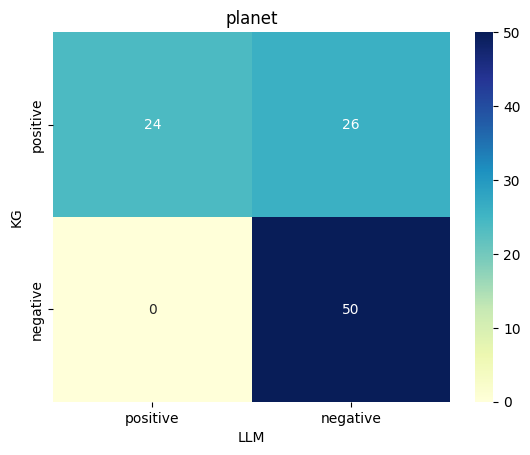

### LLM negative, KG positive

label,description,rationale
DP Leonis b,"DP Leonis b is an extrasolar planet, orbiting the 17th magnitude star DP Leonis, constellation Leo. This 6.28 MJ planet orbits two stars, a white dwarf and a red dwarf, at a separation of about 8.6 AU with unknown eccentricity.","DP Leonis b can be considered a planet based on the given definition. It is a celestial body that is in orbit around two stars, a white dwarf and a red dwarf, which can be considered analogous to orbiting the Sun. The description does not provide information about its mass or shape, but it is implied that it has sufficient mass to maintain a stable orbit. The description also does not specify whether DP Leonis b has cleared the neighbourhood around its orbit, but this is a common characteristic of planets. Therefore, based on the available information, it can be argued that DP Leonis b fits the definition of a planet."
DENIS-P J082303.1−491201 b,"DENIS-P J082303.1-491201 b (alias 2MASS J08230313-4912012 b) is a substellar object, classified as either an exoplanet or a brown dwarf, orbiting DENIS-P J082303.1-491201, an L1.5-type brown dwarf in the constellation Vela.","The description of DENIS-P J082303.1−491201 b indicates that it is a substellar object that orbits DENIS-P J082303.1-491201, which is similar to the first part of the definition of a planet that states it should be in orbit around the Sun. However, in this case, it is orbiting a brown dwarf and not the Sun. The description does not provide information about its mass or shape, or whether it has cleared the neighbourhood around its orbit. Therefore, based solely on the provided definition and description, it is not possible to definitively assert that DENIS-P J082303.1−491201 b is a planet."
WD 0806-661 b,"WD 0806−661 (L 97-3, GJ 3483), formally named Maru, is a DQ white dwarf with an extremely cold Y-type substellar companion (designated ""B""), located in the constellation Volans at 62.7 light-years (19.2 parsecs) from Earth. The companion was discovered in 2011, and is the only known Y-type companion to a star or stellar remnant. At the time of its discovery WD 0806-661 B had the largest actual (2500 AU) and apparent separation (more than 2 arcminutes) of any known planetary-mass object, as well as being the coldest directly imaged substellar object then known.","The entity WD 0806-661 b could be considered a planet based on the provided definition. The description states that it is a substellar companion, which implies that it is in orbit around a star (WD 0806−661), satisfying condition (a) of the definition. The description also mentions that WD 0806-661 b is a planetary-mass object, which suggests that it has sufficient mass for its self-gravity to overcome rigid body forces and assume a hydrostatic equilibrium shape, satisfying condition (b). However, the description does not provide information about whether WD 0806-661 b has cleared the neighbourhood around its orbit, which is condition (c) of the definition. Therefore, based on the available information, it can be argued that WD 0806-661 b meets at least two out of the three conditions to be classified as a planet."
HD 202206 b,"HD 202206 is a binary star system in the southern constellation of Capricornus. With an apparent visual magnitude of +8.1, it is too faint to be visible to the naked eye. It is located at a distance of 150 light years from the Sun based on parallax, and is drifting further away with a radial velocity of +14.7 km/s.The primary component is a G-type main-sequence star with a stellar classification of G6V, indicating it is generating energy through core hydrogen fusion. It is an estimated three billion years old and is spinning with a projected rotational velocity of 2.3 km/s. It is a metal-rich star – what astronomers term the abundance of elements of higher atomic number than helium – which may explain the star's unusually high luminosity for its class. The star has a slightly greater mass and radius compared to th

In [7]:
for experiment in experiment_df["experiment"].values:
    display_experiment(experiment)